# Лабораторная работа 4. Кластеризация"

**Цель работы:** изучение алгоритмов кластеризации, приобретение навыков оценки качества разбиения данных на кластеры и интерпретации результатов.

**Постановка задачи:**

1. Загрузить датасет для задачи кластеризации / классификации (например, с платформы Kaggle). Провести дескриптивный анализ данных: определить размерность, типы признаков, наличие пропусков. Оценить распределение переменных (близость к нормальному) с использованием визуализации (гистограммы). Проверить условие применения кластеризации: отсутствие классов, осмысленность кластеризации, отсутствие выбросов.

2. Выполнить стандартизацию / нормализацию числовых признаков. Обосновать выбор метода масштабирования. Построить матрицу диаграмм рассеивания для визуальной оценки структуры данных, предположительного количества кластеров и типа кластерной структуры. Аргументировать выбор методов кластеризации на основе формы, размера и плотности кластеров.

3. Реализовать кластеризацию двумя различными методами на выбор: K-means (K-средних); иерархическая кластеризация; DBSCAN; EM-алгоритм (Gaussian Mixture). Для методов, требующих задания числа кластеров (K-means, иерархическая), подобрать оптимальное значение k с использованием: метода локтя и / или анализа силуэта.

4. Рассчитать метрики качества для обоих методов: внутренние и внешние. Оценить расстояние между кластерами, внутрикластерные расстояния, компактность кластеров, центры кластеров. Опционально, если известно разделение на классы, посчитать: индекс Rand, индекс Жаккара и др. внешние метрики. Привести содержательную интерпретацию полученных значений.

5. Исследовать влияние параметров одного из методов (например, ε и min_samples для DBSCAN или количества кластеров k для K-means) на качество кластеризации.

6. Визуализировать полученные кластеры в пространстве признаков (использовать PCA для снижения размерности при необходимости). Проанализировать центры кластеров (для K-means) и дать содержательную интерпретацию выделенных групп. Сравнить результаты, полученные двумя разными методами.

In [42]:
import kagglehub

path = kagglehub.dataset_download("prince2004patel/iti-student-dropout-synthetic-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\vaind\.cache\kagglehub\datasets\prince2004patel\iti-student-dropout-synthetic-dataset\versions\1


<h3>Описание датасета</h3>
Этот набор данных содержит 22 признака, относящиеся к демографическим, академическим, личным и семейным характеристикам студентов ITI, а также целевую переменную dropout (Да/Нет). Он был синтетически сгенерирован для исследований и построения моделей машинного обучения для оценки риска отсева студентов.

Набор данных включает следующие категории признаков:

1. **Демография студента**  
   - возраст (`age`): целое, 15–30  
   - пол (`gender`): категориальный (Мужской / Женский)  
   - тип местности (`location_type`): категориальный (Сельская / Полугородская / Городская)  
   - доход семьи (`family_income`): вещественный, INR 2000–50000  
   - расстояние до института (`distance_to_institute`): вещественный, 0.5–50 км  

2. **Академические факторы**  
   - оценки за 10-й класс (`tenth_marks`): вещественный, 0–100  
   - выбранная программа обучения (`program_enrolled`): категориальный (Mechanical / Electrical / ECE / Civil / Welding / Plumbing / Computer IT)  
   - посещаемость (`attendance_rate`): вещественный, 0–100  
   - средний балл тестов (`test_scores_avg`): вещественный, 0–100  
   - оценка практических навыков (`practical_skills_rating`): вещественный, 0–100  
   - долги по предметам (`backlogs`): целое, 0–9  

3. **Вовлечённость и поддержка**  
   - статус финансовой помощи (`financial_aid_status`): категориальный (Нет / Частично / Полная)  
   - работа неполный день (`part_time_work`): категориальный (Да / Нет)  
   - оценка качества преподавания (`teaching_quality_rating`): целое, 1–10  

4. **Личные факторы**  
   - соответствие карьере (`career_alignment`): категориальный (Низкое / Среднее / Высокое)  
   - мотивация (`motivation_score`): целое, 1–10  
   - поддержка семьи (`family_support`): категориальный (Низкая / Средняя / Высокая)  
   - уровень стресса (`stress_levels`): категориальный (Низкий / Средний / Высокий)  

5. **Техническая и цифровая грамотность**  
   - проблемы с интернет-соединением (`internet_connectivity_issues`): категориальный (Нет проблем / Периодические / Частые)  

6. **Семейные и социальные факторы**  
   - количество братьев и сестёр (`num_siblings`): целое, 1–9  
   - образование родителей (`parents_education`): категориальный (Нет / Оба в колледже / Оба в школе / Смешанное)  
   - опыт травли (`ragging_experience`): категориальный (Да / Нет)  

7. **Целевая переменная**  
   - отчисление (`dropout`): категориальный (Да / Нет)

<h3>Импорт библиотек</h3>

In [43]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from sklearn.mixture import GaussianMixture
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import os
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score,
    rand_score, adjusted_rand_score, jaccard_score,
    adjusted_mutual_info_score
)
from scipy.spatial.distance import cdist

<h3>Описательный анализ</h3>

In [67]:
dataset_path = r"F:\ml\datasets\ECommerce_consumer behaviour.csv"
df = pd.read_csv(dataset_path)

print("Первые строки")
print(df.head())
print("\nИнформация о данных")
print(df.info())

Первые строки
   order_id  user_id  order_number  order_dow  order_hour_of_day  \
0   2425083    49125             1          2                 18   
1   2425083    49125             1          2                 18   
2   2425083    49125             1          2                 18   
3   2425083    49125             1          2                 18   
4   2425083    49125             1          2                 18   

   days_since_prior_order  product_id  add_to_cart_order  reordered  \
0                     NaN          17                  1          0   
1                     NaN          91                  2          0   
2                     NaN          36                  3          0   
3                     NaN          83                  4          0   
4                     NaN          83                  5          0   

   department_id  department        product_name  
0             13      pantry  baking ingredients  
1             16  dairy eggs     soy lactosefree

In [68]:
print("\nПропущенные значения по столбцам:")
print(df.isnull().sum())


Пропущенные значения по столбцам:
order_id                       0
user_id                        0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    124342
product_id                     0
add_to_cart_order              0
reordered                      0
department_id                  0
department                     0
product_name                   0
dtype: int64


In [70]:
df = df[(df != 0).all(axis=1)]

In [71]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_numeric = df[numeric_cols]

print("Числовые признаки:", numeric_cols)


Числовые признаки: ['order_id', 'user_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'product_id', 'add_to_cart_order', 'reordered', 'department_id']


KeyboardInterrupt: 

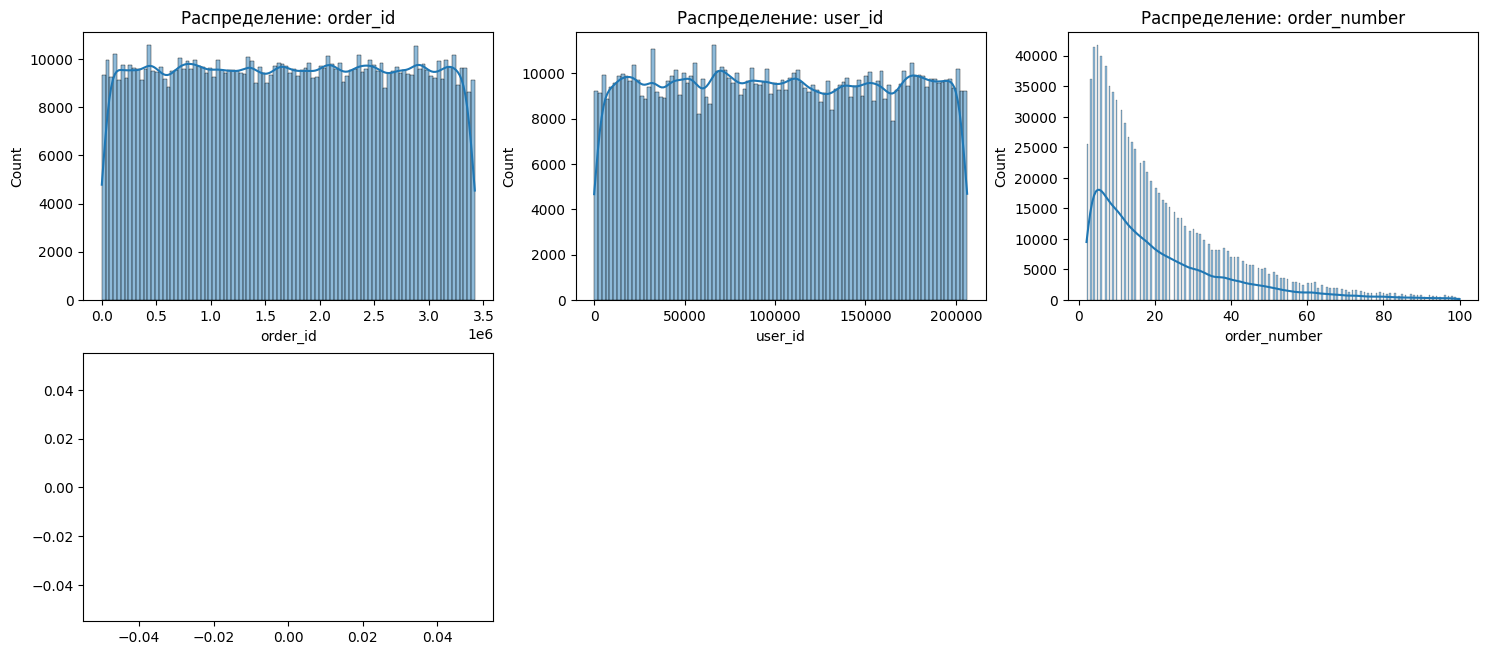

In [72]:
num_cols = len(numeric_cols)
cols_per_row = 3
rows = math.ceil(num_cols / cols_per_row)

plt.figure(figsize=(18, rows * 4))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols_per_row, i)
    sns.histplot(df_numeric[col], kde=True)
    plt.title(f"Распределение: {col}")

plt.tight_layout()
plt.show()

In [ ]:
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])

num_cols = len(numeric_cols)
cols_per_row = 3
rows = math.ceil(num_cols / cols_per_row)

plt.figure(figsize=(18, rows * 4))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols_per_row, i)
    sns.histplot(df_scaled[col], kde=True)
    plt.title(f"Распределение после стандартизации: {col}")

plt.tight_layout()
plt.show()

<b>Вывод:</b> После стандартизации все числовые признаки были приведены к единой шкале с нулевым средним и единичным стандартным отклонением, что явно отражено на графиках распределений - формы гистограмм остались неизменными, но их положение и масштаб по оси X кардинально изменились, что подтверждает корректное применение StandardScaler. Этот метод выбран потому, что он оптимален для признаков с приблизительно нормальным распределением, не требует предположений о границах данных и менее чувствителен к выбросам по сравнению с MinMaxScaler.

<Figure size 2000x2000 with 0 Axes>

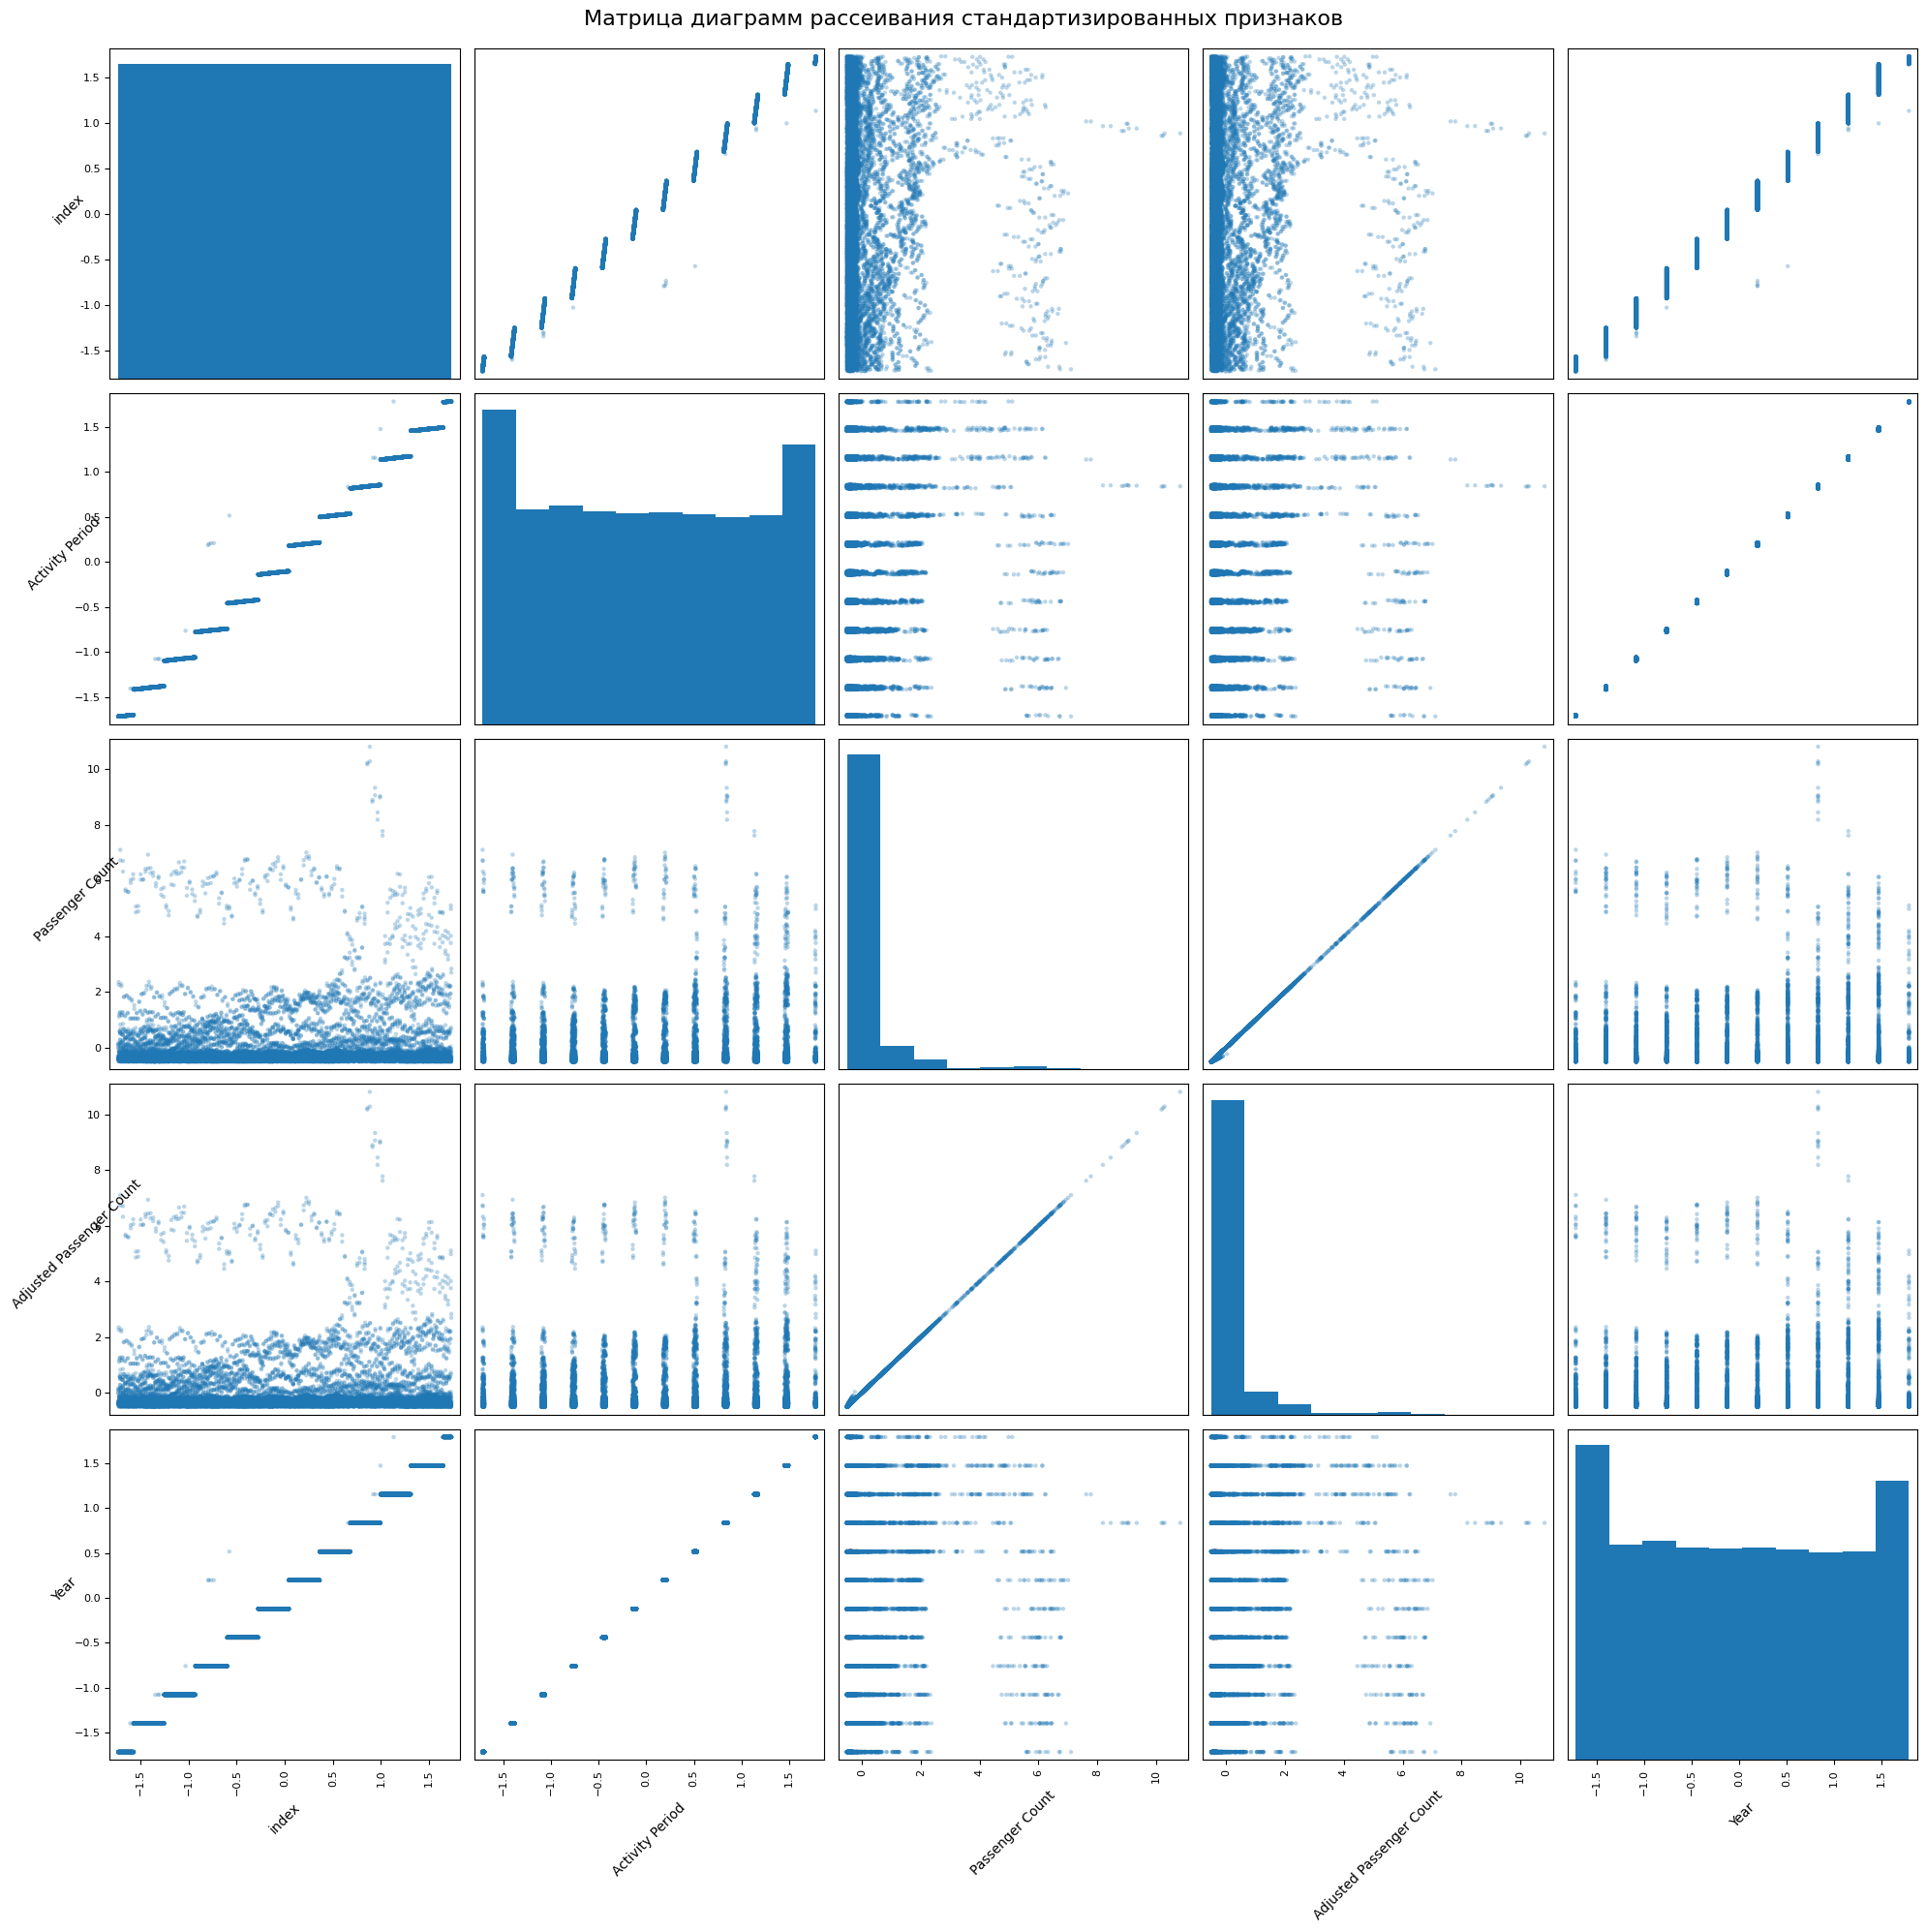

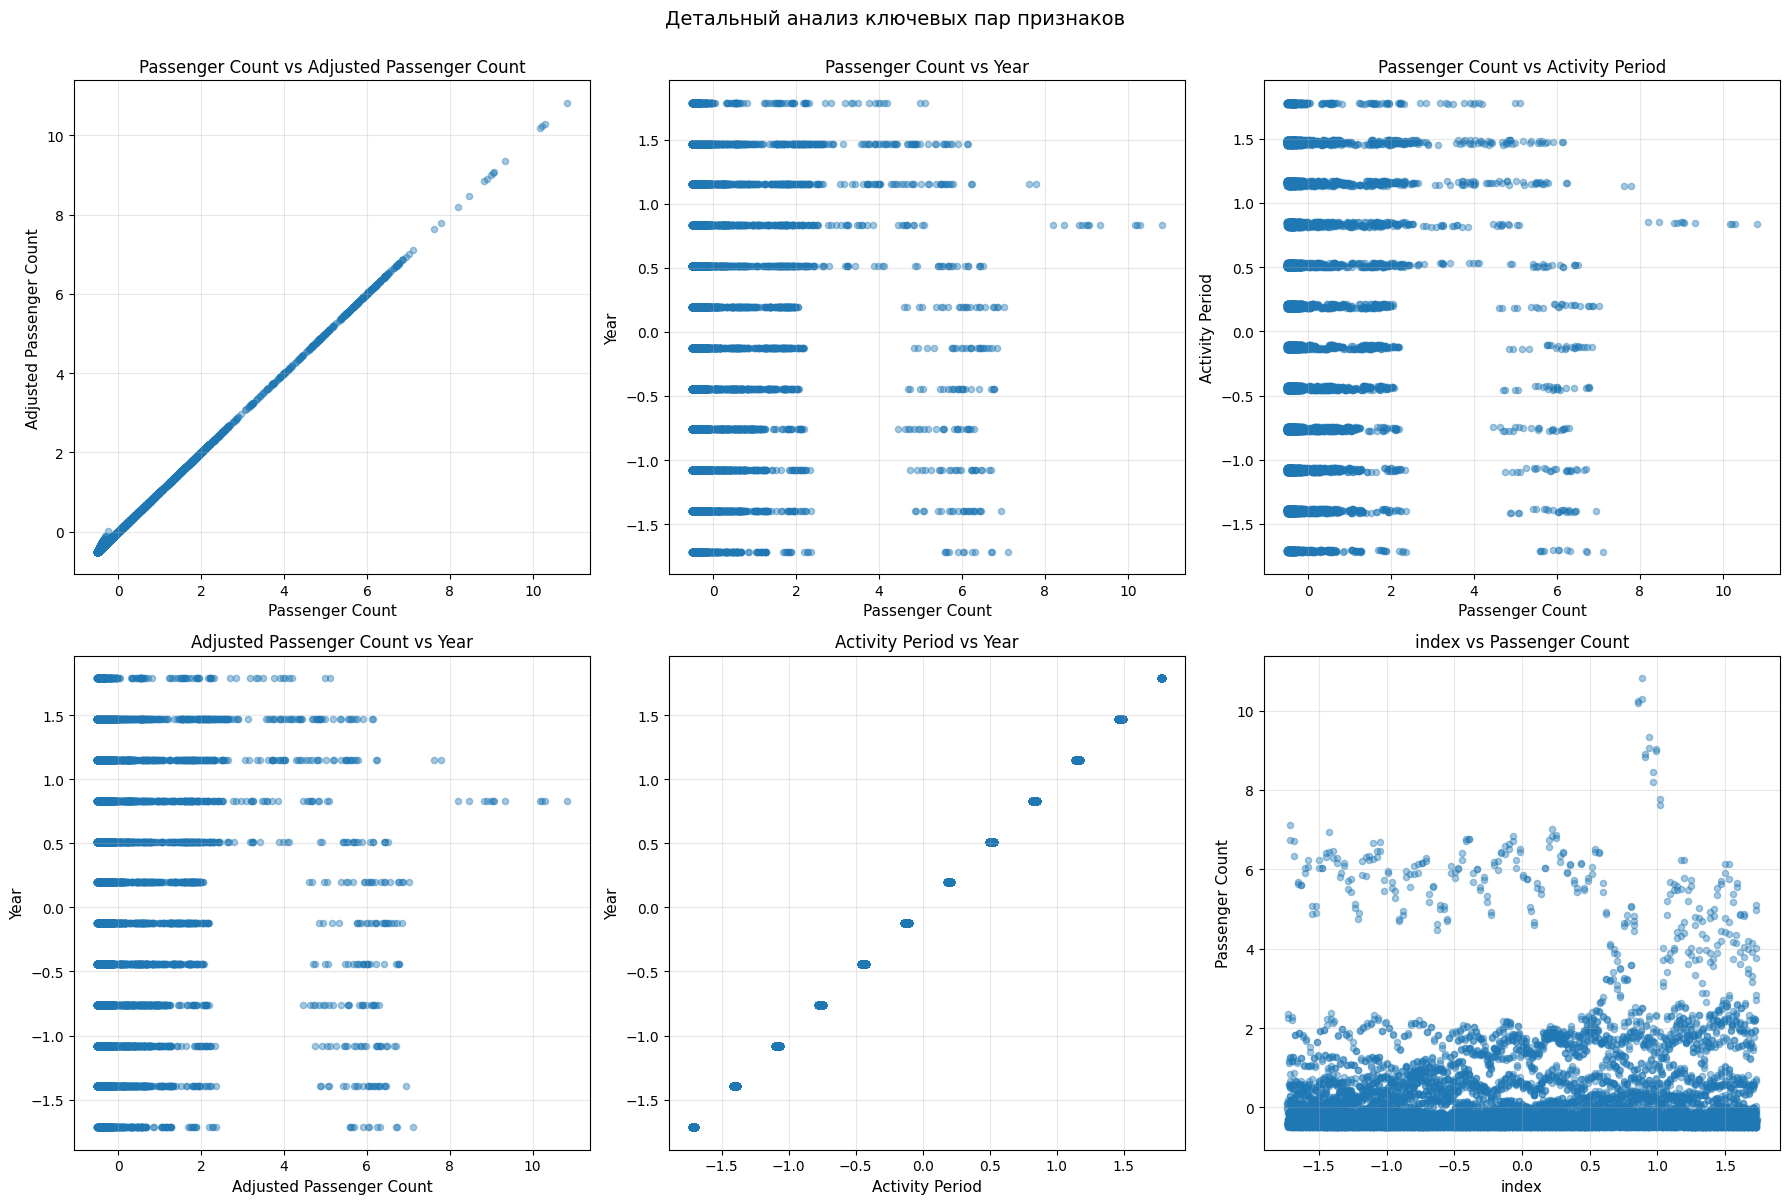

In [ ]:
numeric_cols =['order_id', 'user_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'product_id', 'add_to_cart_order', 'reordered', 'department_id']

plt.figure(figsize=(20, 20))
scatter_matrix = pd.plotting.scatter_matrix(
    df_scaled[numeric_cols],
    alpha=0.3,
    figsize=(20, 20),
    diagonal='hist',
    marker='o',
    s=10
)
 
for ax in scatter_matrix.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize=10, rotation=45)
    ax.set_ylabel(ax.get_ylabel(), fontsize=10, rotation=45)

plt.suptitle('Матрица диаграмм рассеивания стандартизированных признаков', 
             fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

interesting_pairs = [
    ('order_number', 'days_since_prior_order'),
    ('order_hour_of_day', 'order_dow'),
    ('product_id', 'add_to_cart_order'),
    ('order_number', 'reordered'),
    ('order_dow', 'days_since_prior_order'),
    ('department_id', 'reordered')
]

for idx, (feature1, feature2) in enumerate(interesting_pairs):
    axes[idx].scatter(df_scaled[feature1], df_scaled[feature2], 
                      alpha=0.4, s=20)
    axes[idx].set_xlabel(feature1, fontsize=11)
    axes[idx].set_ylabel(feature2, fontsize=11)
    axes[idx].set_title(f'{feature1} vs {feature2}', fontsize=12)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Детальный анализ ключевых пар признаков', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

<b>Вывод:</b> Визуальный анализ матрицы диаграмм рассеивания показывает, что данные не содержат четко выраженных кластеров; наблюдается единое облако точек с плавными переходами и отсутствием резких границ между группами. Некоторые пары признаков демонстрируют сильные линейные зависимости (например, `income` и `gdpp`, `child_mort` и `life_expec`), что указывает на высокую корреляцию, в то время как другие — слабую или нелинейную связь. Структура данных подходит для методов кластеризации, основанных на центроидах, таких как K-Means, который сможет выделить группы на основе средних значений и расстояний. Также целесообразно применить иерархическую кластеризацию для визуального определения оптимального числа кластеров через дендрограмму и Gaussian Mixture Models для учета вероятностных распределений и перекрытия групп. Метод DBSCAN, требующий плотных областей и ясных границ, в данном случае будет неэффективен из-за равномерного распределения точек и отсутствия разреженных зон.

In [ ]:
numerical_features = ['index', 'Activity Period', 'Passenger Count', 'Adjusted Passenger Count', 'Year']
X = df_scaled[numerical_features].values
k_range = range(2, 11)

kmeans_inertia = []
kmeans_silhouette = []
kmeans_davies_bouldin = []

hierarchical_silhouette = []
hierarchical_davies_bouldin = []

gmm_bic = []
gmm_aic = []
gmm_silhouette = []

print("\nВычисление метрик для различных значений k...\n")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X)
    kmeans_inertia.append(kmeans.inertia_)
    kmeans_silhouette.append(silhouette_score(X, kmeans_labels))
    kmeans_davies_bouldin.append(davies_bouldin_score(X, kmeans_labels))
    
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels = gmm.fit_predict(X)
    gmm_bic.append(gmm.bic(X))
    gmm_aic.append(gmm.aic(X))
    gmm_silhouette.append(silhouette_score(X, gmm_labels))
    
    print(f"k={k}: K-Means Silhouette={kmeans_silhouette[-1]:.3f}, "
          f"GMM Silhouette={gmm_silhouette[-1]:.3f}")


Вычисление метрик для различных значений k...

k=2: K-Means Silhouette=0.502, GMM Silhouette=-0.103
k=3: K-Means Silhouette=0.539, GMM Silhouette=-0.052
k=4: K-Means Silhouette=0.463, GMM Silhouette=-0.089
k=5: K-Means Silhouette=0.510, GMM Silhouette=-0.058
k=6: K-Means Silhouette=0.472, GMM Silhouette=0.192
k=7: K-Means Silhouette=0.492, GMM Silhouette=0.216
k=8: K-Means Silhouette=0.493, GMM Silhouette=0.248
k=9: K-Means Silhouette=0.473, GMM Silhouette=-0.012
k=10: K-Means Silhouette=0.480, GMM Silhouette=-0.050


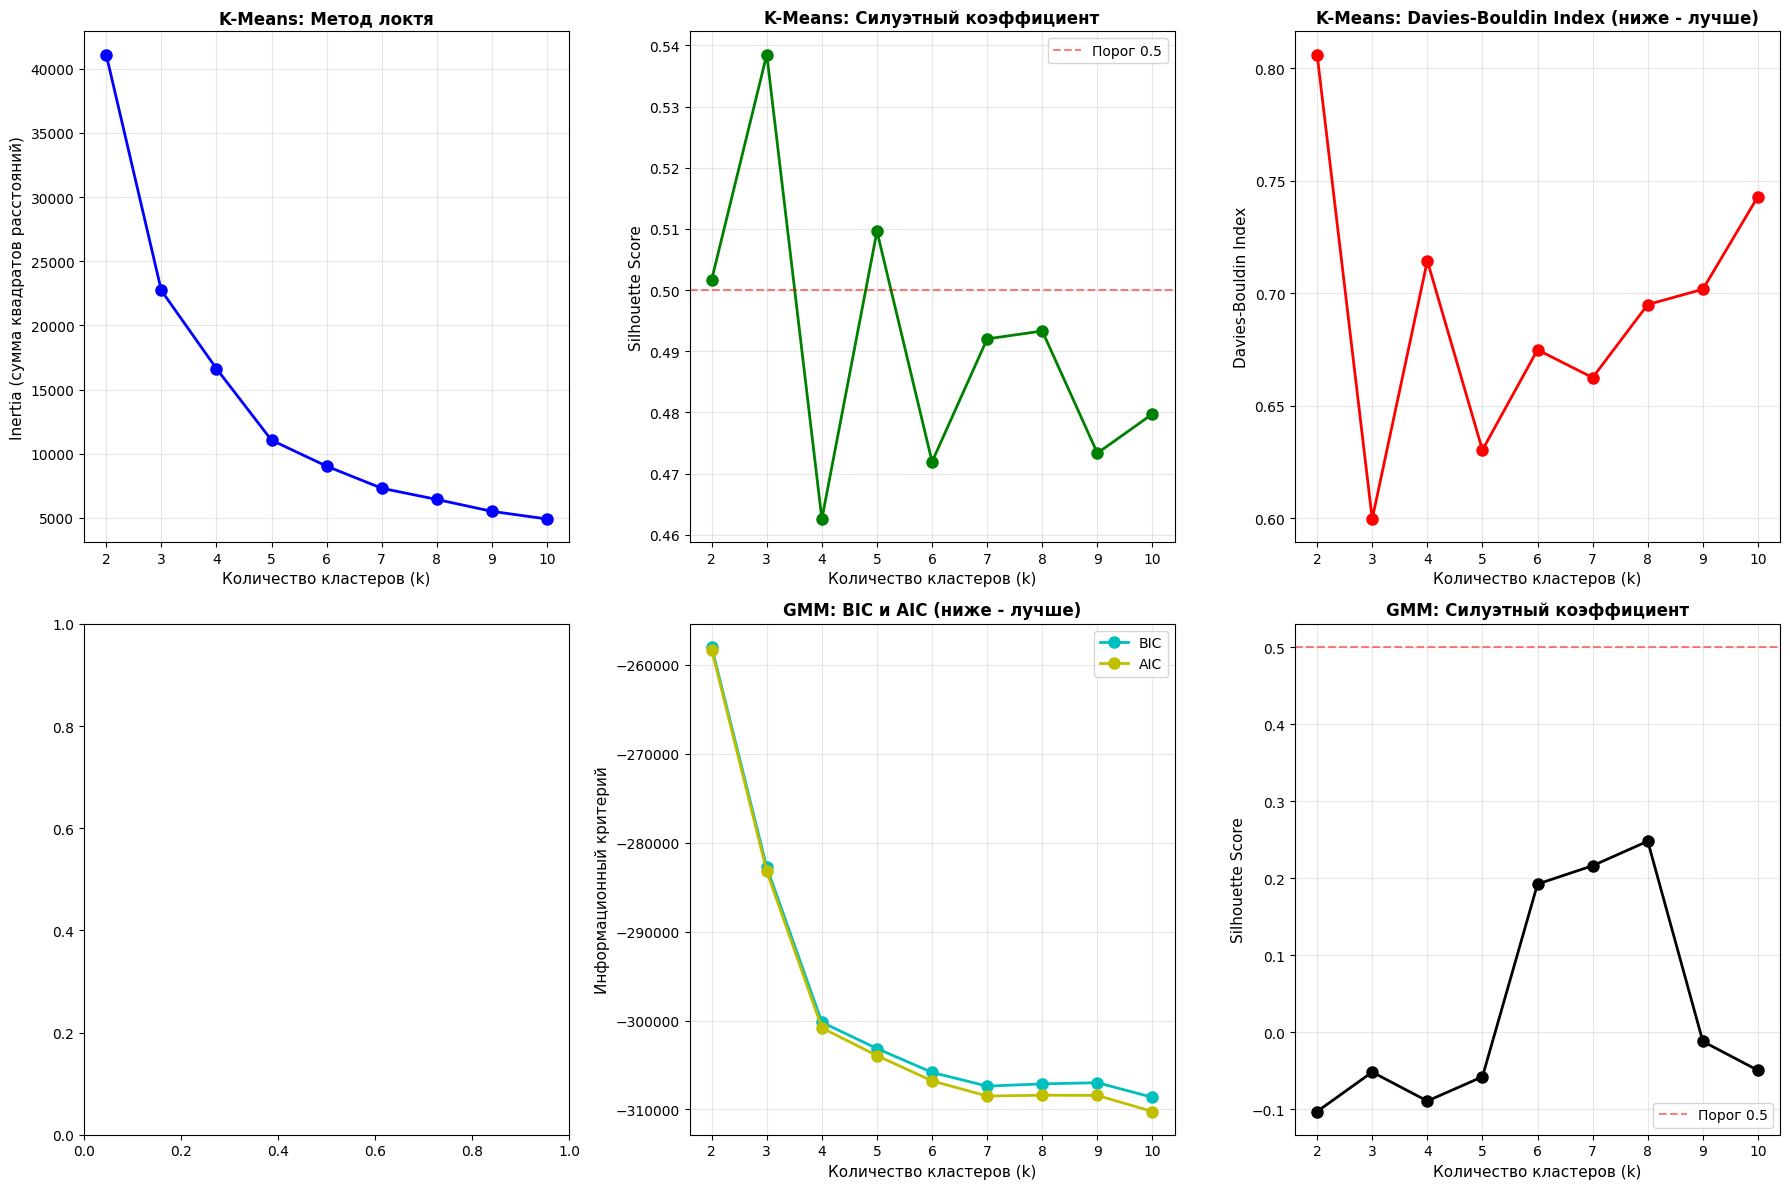

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# K-Means: Метод локтя
axes[0, 0].plot(k_range, kmeans_inertia, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Количество кластеров (k)', fontsize=11)
axes[0, 0].set_ylabel('Inertia (сумма квадратов расстояний)', fontsize=11)
axes[0, 0].set_title('K-Means: Метод локтя', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(k_range)

# K-Means: Силуэтный анализ
axes[0, 1].plot(k_range, kmeans_silhouette, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Количество кластеров (k)', fontsize=11)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=11)
axes[0, 1].set_title('K-Means: Силуэтный коэффициент', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(k_range)
axes[0, 1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Порог 0.5')
axes[0, 1].legend()

# K-Means: Davies-Bouldin Index
axes[0, 2].plot(k_range, kmeans_davies_bouldin, 'ro-', linewidth=2, markersize=8)
axes[0, 2].set_xlabel('Количество кластеров (k)', fontsize=11)
axes[0, 2].set_ylabel('Davies-Bouldin Index', fontsize=11)
axes[0, 2].set_title('K-Means: Davies-Bouldin Index (ниже - лучше)', fontsize=12, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_xticks(k_range)

# GMM: BIC и AIC
ax_gmm = axes[1, 1]
ax_gmm.plot(k_range, gmm_bic, 'co-', linewidth=2, markersize=8, label='BIC')
ax_gmm.plot(k_range, gmm_aic, 'yo-', linewidth=2, markersize=8, label='AIC')
ax_gmm.set_xlabel('Количество кластеров (k)', fontsize=11)
ax_gmm.set_ylabel('Информационный критерий', fontsize=11)
ax_gmm.set_title('GMM: BIC и AIC (ниже - лучше)', fontsize=12, fontweight='bold')
ax_gmm.grid(True, alpha=0.3)
ax_gmm.set_xticks(k_range)
ax_gmm.legend()

# GMM: Силуэтный анализ
axes[1, 2].plot(k_range, gmm_silhouette, 'ko-', linewidth=2, markersize=8)
axes[1, 2].set_xlabel('Количество кластеров (k)', fontsize=11)
axes[1, 2].set_ylabel('Silhouette Score', fontsize=11)
axes[1, 2].set_title('GMM: Силуэтный коэффициент', fontsize=12, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].set_xticks(k_range)
axes[1, 2].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Порог 0.5')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

<b>Вывод:</b> Анализ метрик для подбора оптимального числа кластеров показывает, что данные не обладают четкой естественной кластерной структурой. Метод локтя для K-Means демонстрирует плавное снижение inertia без выраженного излома, что затрудняет выбор k. Силуэтный коэффициент для K-Means достигает максимума при k=3 (около 0.54), что является хорошим показателем, но при этом Davies-Bouldin Index имеет минимальное значение при k=3, указывая на наиболее компактные и разделенные кластеры. Для Gaussian Mixture Model информационные критерии BIC и AIC монотонно уменьшаются с ростом k, что может свидетельствовать о переобучении, а силуэтный коэффициент достигает пика при k=8, но остается значительно ниже, чем у K-Means. На основе комплексного анализа, включая высокий силуэтный коэффициент и низкий Davies-Bouldin Index, было принято решение использовать k=3 как оптимальное количество кластеров для финальной модели K-Means, поскольку это значение обеспечивает наилучший баланс между компактностью кластеров и их разделимостью, несмотря на отсутствие явных границ в исходных данных.

In [ ]:

k = 3
has_true_labels = 'y_true' in globals()

kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
labels_km = kmeans.labels_
centers_km = kmeans.cluster_centers_

sil_km = silhouette_score(X, labels_km)
dbi_km = davies_bouldin_score(X, labels_km)
ch_km = calinski_harabasz_score(X, labels_km)
inertia_km = kmeans.inertia_

intercluster_dist_km = cdist(centers_km, centers_km)
compactness_km = np.mean([
    np.mean(np.linalg.norm(X[labels_km == i] - centers_km[i], axis=1))
    for i in range(k)
])

gmm = GaussianMixture(n_components=k, random_state=42).fit(X)
labels_gmm = gmm.predict(X)
centers_gmm = gmm.means_

sil_gmm = silhouette_score(X, labels_gmm)
dbi_gmm = davies_bouldin_score(X, labels_gmm)
ch_gmm = calinski_harabasz_score(X, labels_gmm)
bic_gmm = gmm.bic(X)
aic_gmm = gmm.aic(X)

intercluster_dist_gmm = cdist(centers_gmm, centers_gmm)
compactness_gmm = np.mean([
    np.mean(np.linalg.norm(X[labels_gmm == i] - centers_gmm[i], axis=1))
    for i in range(k)
])

if has_true_labels:
    ri_km = rand_score(y_true, labels_km)
    ari_km = adjusted_rand_score(y_true, labels_km)
    jaccard_km = jaccard_score(y_true, labels_km, average='macro')
    ami_km = adjusted_mutual_info_score(y_true, labels_km)

    ri_gmm = rand_score(y_true, labels_gmm)
    ari_gmm = adjusted_rand_score(y_true, labels_gmm)
    jaccard_gmm = jaccard_score(y_true, labels_gmm, average='macro')
    ami_gmm = adjusted_mutual_info_score(y_true, labels_gmm)

print("\nK-MEANS")
print(f"Silhouette: {sil_km:.4f}")
print(f"Davies-Bouldin: {dbi_km:.4f}")
print(f"Calinski-Harabasz: {ch_km:.2f}")
print(f"Inertia: {inertia_km:.2f}")
print(f"Compactness: {compactness_km:.4f}")
print(f"Intercluster distances:\n{intercluster_dist_km}")
print(f"Centers:\n{centers_km}")

if has_true_labels:
    print("\nExternal metrics")
    print(f"Rand Index: {ri_km:.4f}")
    print(f"Adjusted Rand: {ari_km:.4f}")
    print(f"Jaccard: {jaccard_km:.4f}")
    print(f"AMI: {ami_km:.4f}")

print("\nGMM")
print(f"Silhouette: {sil_gmm:.4f}")
print(f"Davies-Bouldin: {dbi_gmm:.4f}")
print(f"Calinski-Harabasz: {ch_gmm:.2f}")
print(f"BIC: {bic_gmm:.2f}")
print(f"AIC: {aic_gmm:.2f}")
print(f"Compactness: {compactness_gmm:.4f}")
print(f"Intercluster distances:\n{intercluster_dist_gmm}")
print(f"Centers:\n{centers_gmm}")

if has_true_labels:
    print("\nExternal metrics")
    print(f"Rand Index: {ri_gmm:.4f}")
    print(f"Adjusted Rand: {ari_gmm:.4f}")
    print(f"Jaccard: {jaccard_gmm:.4f}")
    print(f"AMI: {ami_gmm:.4f}")



K-MEANS
Silhouette: 0.5021
Davies-Bouldin: 0.8055
Calinski-Harabasz: 12386.49
Inertia: 41104.16
Compactness: 1.2113
Intercluster distances:
[[0.         3.00787115]
 [3.00787115 0.        ]]
Centers:
[[-0.84874301 -0.84966825 -0.07767434 -0.07691247 -0.84929174]
 [ 0.88207454  0.88303612  0.08072474  0.07993295  0.88264482]]

GMM
Silhouette: -0.1029
Davies-Bouldin: 2.4679
Calinski-Harabasz: 171.96
BIC: -258031.30
AIC: -258343.57
Compactness: 1.5175
Intercluster distances:
[[0.         1.23190775]
 [1.23190775 0.        ]]
Centers:
[[-0.5905481  -0.57808816 -0.45450328 -0.41858383 -0.57713376]
 [ 0.02478551  0.02426256  0.01907566  0.01756811  0.0242225 ]]
